# Project - AI for Medical Diagnosis and Prediction | Week #2

In this notebook, we begin our analysis of the MIMIC-CXR dataset by exploring, cleaning, and organizing the data. The objective is to prepare a high-quality dataset for downstream tasks in machine learning and deep learning.

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Load and examine the dataset structure and contents <i>(Task 1)</i> <br>
- Clean the metadata by removing or imputing missing values <i>(Task 2)</i> <br>
- Anonymize DICOM images if necessary <i>(Task 2*)</i> <br>
- Extract informative features from images and radiology reports <i>(Task 3)</i> <br>
- Standardize features and identify outliers <i>(Task 4)</i> <br>
- Apply dimensionality reduction (PCA, t-SNE) to visualize the feature space <i>(Task 5)</i> <br>
- Select and store the most relevant features for model training <i>(Task 5)</i> <br>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [147]:
# System deps for PyRadiomics
!apt-get update -qq
!apt-get install -y build-essential cmake libpython3-dev

# Python packages
!pip install pydicom SimpleITK scikit-learn -q
!pip install pynrrd
!pip install git+https://github.com/AIM-Harvard/pyradiomics.git

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
libpython3-dev is already the newest version (3.10.6-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


  3%|▎         | 23/669 [11:21<5:19:02, 29.63s/it]


  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-moe8ssjn
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-moe8ssjn
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [148]:
import pydicom
import nrrd
import SimpleITK as sitk
import numpy as np
import pandas as pd
from sklearn import model_selection
from radiomics import featureextractor

In [149]:
import SimpleITK as sitk
import numpy as np

def load_dicom_series_to_3d_image(dicom_dir):
    """Load a DICOM series into a 3D SimpleITK image."""
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def convert_np_to_sitk(np_array, reference_image=None):
    """Convert a NumPy array to a SimpleITK image, preserving metadata."""
    sitk_image = sitk.GetImageFromArray(np_array)
    if reference_image is not None:
        sitk_image.CopyInformation(reference_image)
    return sitk_image

def reconstruct_mask_in_image_space(mask_np, reference_image):
    """Reconstruct a binary mask in the space of a reference image."""
    mask_sitk = convert_np_to_sitk(mask_np, reference_image)
    mask_sitk = sitk.Cast(mask_sitk, sitk.sitkUInt8)
    return mask_sitk

In [150]:
import pandas as pd
import numpy as np
import pydicom
import nrrd

import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from glob import glob
from radiomics import featureextractor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCAN

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

import sys
sys.path.append('../')

In [151]:
DATA_PATH = '../data/MIMIC-CXR'

Run the following cells to download and unzip the dataset.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the folder. By default, it will be stored in the data folder at the root of the directory.</b> <br>
<b>If you have already downloaded the dataset, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [152]:
!mkdir -p {DATA_PATH}
!wget https://uni-bonn.sciebo.de/s/YHuwFOg6q6sw1ZX/download --output-document {DATA_PATH}/MIMIC-CXR.zip
!unzip {DATA_PATH}/MIMIC-CXR.zip

--2025-09-14 23:37:52--  https://uni-bonn.sciebo.de/s/YHuwFOg6q6sw1ZX/download
Resolving uni-bonn.sciebo.de (uni-bonn.sciebo.de)... 128.176.1.2
Connecting to uni-bonn.sciebo.de (uni-bonn.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8281720521 (7.7G) [application/zip]
Saving to: ‘../data/MIMIC-CXR/MIMIC-CXR.zip’

../data/MIMIC-CXR/M 100%[===================>]   7.71G  23.8MB/s    in 5m 39s  

2025-09-14 23:43:32 (23.3 MB/s) - ‘../data/MIMIC-CXR/MIMIC-CXR.zip’ saved [8281720521/8281720521]

Archive:  ../data/MIMIC-CXR/MIMIC-CXR.zip
replace MIMIC-CXR/cxr-record-list.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Task 1: Data Exploration

<div class="alert alert-block alert-info">
<b>1.</b> Load the different csv files contained in the dataset and explore their content.
</div>

Each file provide different information about the dataset.

* `study_df` contains patients and study ids with the corresponding radiology reports ;
* `record_df` contains patients and study ids with corresponding DICOM ids and image paths ;
* `provider_df` contains ids of data providers ;
* `mask_df` contains the patients and study ids with paths to their corresponding masks.

In [153]:
!unzip {DATA_PATH}/MIMIC-CXR.zip -d {DATA_PATH}

Archive:  ../data/MIMIC-CXR/MIMIC-CXR.zip
replace ../data/MIMIC-CXR/MIMIC-CXR/cxr-record-list.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [154]:
study_df = pd.read_csv(f'{DATA_PATH}/MIMIC-CXR/cxr-study-list.csv.gz')
record_df = pd.read_csv(f'{DATA_PATH}/MIMIC-CXR/cxr-record-list.csv.gz')
provider_df = pd.read_csv(f'{DATA_PATH}/MIMIC-CXR/cxr-provider-list.csv.gz')
mask_df = pd.read_csv(f'{DATA_PATH}/MIMIC-CXR/cxr-mask-list.csv')

<div class="alert alert-block alert-info">
<b>2.</b> Search for available image (<code>record</code>), segmentation (<code>mask</code>) and report (<code>study</code>) files in the directory. Create dataframes containing only the information about the subjects with available files. Name these dataframe <code>subset_{df_name}</code>.
</div>

In [155]:
# Get list of image paths of available data
file_list = glob(f'{DATA_PATH}/MIMIC-CXR/files/*/*/*/*.dcm') # Path to images. Use * to search within all folders.

# Check for corrupted files
valid_file_list = []
for f in file_list:
    try:
        img = pydicom.dcmread(f).pixel_array
        valid_file_list.append(f)
    except:
        continue
file_list = [f[len(f'{DATA_PATH}/MIMIC-CXR/') :] for f in valid_file_list]

# Get subset csv files with only information on available subjects
subset_record_df = record_df.loc[record_df['path'].isin(file_list)]
subset_record_df.head()

,subject_id,study_id,dicom_id,path
301504,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,files/p18/p18000291/s55388853/04564240-d4e9e69...
301505,18000291,55388853,a17c02b3-7c360f2c-a07734a0-76867697-36d59d3d,files/p18/p18000291/s55388853/a17c02b3-7c360f2...
301506,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,files/p18/p18000291/s55388853/ed82a88d-499bed8...
301507,18000379,51062789,4885a037-6d0efe8b-97d2955b-eb046c9f-3f5d89b6,files/p18/p18000379/s51062789/4885a037-6d0efe8...
301508,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...


In [156]:
## Get list of available reports
file_study_list = glob(f'{DATA_PATH}/MIMIC-CXR/files/*/*/*.txt') # Path to text reports. Use * to search within all folders.
file_study_list = [f[len(f'{DATA_PATH}/MIMIC-CXR/') :] for f in file_study_list]

# Get subset csv files with only information on available subjects
subset_study_df = study_df.loc[study_df['path'].isin(file_study_list)] # COMPLETE to select only samples with study_df['path'] in file_study_list
subset_study_df.head()

,subject_id,study_id,path
182076,18000291,55388853,files/p18/p18000291/s55388853.txt
182077,18000379,51062789,files/p18/p18000379/s51062789.txt
182078,18000379,51568340,files/p18/p18000379/s51568340.txt
182079,18000379,51817182,files/p18/p18000379/s51817182.txt
182080,18000379,53632378,files/p18/p18000379/s53632378.txt


In [185]:
import os
import pandas as pd
from glob import glob

# Define the one, correct path to the directory that contains the 'files' and 'segmentation' folders.
CORRECT_DATA_DIR = '../data/MIMIC-CXR/MIMIC-CXR'

# First, let's verify that this directory actually exists.
if not os.path.isdir(CORRECT_DATA_DIR):
    print(f"❌ Directory NOT FOUND at: {CORRECT_DATA_DIR}")
    print("Please check that your data was unzipped into this location.")
else:
    print(f"✅ Found data directory at: {CORRECT_DATA_DIR}")

    # Now, find all mask files using this correct path
    search_pattern = os.path.join(CORRECT_DATA_DIR, 'segmentation', '*', '*', '*.png')
    file_mask_list = glob(search_pattern)

    # Trim the long path prefix to match the format in the 'mask_df' DataFrame
    # The part we want to remove is '/path/to/your/data/MIMIC-CXR/MIMIC-CXR/'
    prefix_to_trim = CORRECT_DATA_DIR + '/'
    trimmed_mask_list = [f[len(prefix_to_trim):] for f in file_mask_list]

    # Create the final subset dataframe by matching the trimmed paths
    subset_mask_df = mask_df.loc[mask_df['mask_path'].isin(trimmed_mask_list)]

    print(f"\nFound {len(file_mask_list)} mask files on disk.")
    print(f"Created a subset dataframe with {len(subset_mask_df)} entries.")

    # Display the first few rows to confirm it's no longer empty
    display(subset_mask_df.head())

✅ Found data directory at: ../data/MIMIC-CXR/MIMIC-CXR

Found 6616 mask files on disk.
Created a subset dataframe with 6616 entries.


,subject_id,study_id,mask_path,dicom_id
0,18000291,55388853,segmentation/18000291/55388853/04564240-d4e9e6...,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743
1,18000291,55388853,segmentation/18000291/55388853/ed82a88d-499bed...,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee
2,18000379,51062789,segmentation/18000379/51062789/eac2b8fa-9245fe...,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b
3,18000379,51568340,segmentation/18000379/51568340/3631ff3b-cfcb24...,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb
4,18000379,51817182,segmentation/18000379/51817182/f6f04111-c3fde2...,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2


## Task 2: Data Cleaning

Now, we will merge the three dataframes to keep only the rows corresponding to images with:
* Available DICOM file;
* Available report;
* Available segmentation mask.

In [186]:
metadata_df = pd.merge(subset_record_df, subset_study_df, on=['study_id', 'subject_id'])
metadata_df = pd.merge(metadata_df, subset_mask_df, on=['study_id', 'subject_id','dicom_id'])
metadata_df.columns = ['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'report_path', 'mask_path']

metadata_df.head()

,subject_id,study_id,dicom_id,dicom_path,report_path,mask_path
0,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,files/p18/p18000291/s55388853/04564240-d4e9e69...,files/p18/p18000291/s55388853.txt,segmentation/18000291/55388853/04564240-d4e9e6...
1,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,files/p18/p18000291/s55388853/ed82a88d-499bed8...,files/p18/p18000291/s55388853.txt,segmentation/18000291/55388853/ed82a88d-499bed...
2,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...,files/p18/p18000379/s51062789.txt,segmentation/18000379/51062789/eac2b8fa-9245fe...
3,18000379,51568340,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,files/p18/p18000379/s51568340/3631ff3b-cfcb244...,files/p18/p18000379/s51568340.txt,segmentation/18000379/51568340/3631ff3b-cfcb24...
4,18000379,51817182,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,files/p18/p18000379/s51817182/f6f04111-c3fde25...,files/p18/p18000379/s51817182.txt,segmentation/18000379/51817182/f6f04111-c3fde2...


<div class="alert alert-block alert-info">
<b>3.</b> Load one of the DICOM image. Observe the header and locate potential metadata that require anonymization.
</div>

In [191]:
image_fname = f'{DATA_PATH}/' + metadata_df.iloc[0]['dicom_path']
image = pydicom.dcmread(image_fname) # COMPLETE with pydicom function to read the image
image

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 204
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.5764793288502811401512973828422394829
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 2.25.55362949469033348352269585565668676650
(0002,0013) Implementation Version Name         SH: 'MIMIC-CXR v2.0.0'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008,0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008,0018) SOP Instance UID                    UI: 2.25.5764793288502811401512973828422394829
(0008,0

All necessary anonymization was already performed. But, we notice that a few elements from the headers could be interesting to add to our `metadata_df`. In particular:
* `ProcedureCodeSequence_CodeMeaning`
* `ViewCodeSequence_CodeMeaning`
* `PatientOrientationCodeSequence_CodeMeaning`

We will extract these information for all available DICOM files and integrate them to the dataframe.

In [193]:
# Place holder lists for metadata
procedure = []
view = []
patient_orientation = []

for dcm_file in metadata_df['dicom_path']:
    image = pydicom.dcmread(f'{DATA_PATH}/' + dcm_file)

    if image.get_item('ProcedureCodeSequence') and image.ProcedureCodeSequence: # Search for the ProcedureCodeSequence item in DICOM header and check if it's not empty
        procedure.append(image.ProcedureCodeSequence[0].CodeMeaning) # Add the CodeMeaning value to procedure list
    else:
        procedure.append(np.nan) # Input NaN

    # COMPLETE : Do the same with the CodeMeaning value of the ViewCodeSequence item. Append it to the view list.
    if image.get_item('ViewCodeSequence') and image.ViewCodeSequence: # Search for the ViewCodeSequence item in DICOM header and check if it's not empty
        view.append(image.ViewCodeSequence[0].CodeMeaning) # Add the CodeMeaning value to view list
    else: # If not available
        view.append(np.nan) # Add np.nan to the view list

    if image.get_item('PatientOrientationCodeSequence') and image.PatientOrientationCodeSequence: # Search for the PatientOrientationCodeSequence item in DICOM header and check if it's not empty
        patient_orientation.append(image.PatientOrientationCodeSequence[0].CodeMeaning) # Add the CodeMeaning value to patient_orientation list
    else:
        patient_orientation.append(np.nan) # Input NaN


metadata_df['ProcedureCodeSequence_CodeMeaning'] = procedure
metadata_df['ViewCodeSequence_CodeMeaning'] = view
metadata_df['PatientOrientationCodeSequence_CodeMeaning'] = patient_orientation

<div class="alert alert-block alert-info">
<b>4.</b> Save the cleaned dataframe as a csv file. Use the name <code>metadata_clean.csv`</code>.
</div>

In [194]:
metadata_df.to_csv('metadata_clean.csv', index=False) # COMPLETE with function to save the dataframe.

## Task 3: Feature Extraction

<div class="alert alert-block alert-info">
<b>6.</b> Load segmentation masks and run radiomic extraction. Check segmentation mask shape, if needed adjust extraction with mask relocation. Save the extracted features in a csv file named <code>features_raw.csv</code>.
</div>

In [195]:
settings = {}

# Normalizes the image by centering it at the mean with standard deviation.
# Normalization is based on all gray values in the image, not just those inside the segmentation.
settings['normalize'] = True
settings['label'] = 255

# Create the featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'normalize': True, 'label': 255}


In [197]:
import SimpleITK as sitk
from radiomics import featureextractor
import os
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# --- 1. Configure the Extractor with All Optimizations ---
# This tells PyRadiomics to use the correct label AND to resample for speed.
settings = {
    'label': 1,
    'geometryTolerance': 1e-6,
    'resampledPixelSpacing': [2.0, 2.0]  # Resample to 2mm x 2mm pixels
}

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
# You can customize which feature classes to enable
extractor.enableFeatureClassByName('firstorder')
extractor.enableFeatureClassByName('glcm')
extractor.enableFeatureClassByName('shape')

# --- 2. Define a Robust Function to Process One Image ---
def extract_features_for_one_case(row):
    """
    Loads data, corrects any mismatches, and extracts features for a single image.
    """
    # Use the correct, nested path to your data
    base_data_path = '../data/MIMIC-CXR/MIMIC-CXR'
    dicom_path = os.path.join(base_data_path, row['dicom_path'])
    mask_path = os.path.join(base_data_path, row['mask_path'])

    if not os.path.exists(dicom_path) or not os.path.exists(mask_path):
        return None

    try:
        # Load the image and correct its dimension if it's 3D
        image_sitk = sitk.ReadImage(dicom_path, sitk.sitkFloat64)
        if image_sitk.GetDimension() == 3:
            image_sitk = image_sitk[:, :, 0]

        # Load the mask and ensure it's a 2D array
        mask_array = plt.imread(mask_path)
        if mask_array.ndim == 3:
            mask_array = mask_array[:, :, 0]
        mask_sitk = sitk.GetImageFromArray(mask_array.astype(np.uint8))

        # Align geometry by copying info from the image to the mask
        mask_sitk.CopyInformation(image_sitk)

        # Extract the features
        result = extractor.execute(image_sitk, mask_sitk)

        # Add identifiers for later use
        result.update({
            "subject_id": row["subject_id"],
            "study_id": row["study_id"],
            "dicom_id": row['dicom_id']
        })
        return result
    except Exception as e:
        # If any unexpected error occurs, skip this image
        return None

# --- 3. Run Extraction in Parallel ---
print("🚀 Starting optimized, parallel feature extraction...")
rows_to_process = metadata_df.to_dict('records')

# Use joblib to run the function on all available CPU cores
results = Parallel(n_jobs=-1)(delayed(extract_features_for_one_case)(row) for row in tqdm(rows_to_process))

# Filter out any cases that failed
successful_results = [r for r in results if r is not None]

# --- 4. Save the Final Results to a Single File ---
if successful_results:
    features_raw_df = pd.DataFrame(successful_results)
    output_path = "features_raw.csv"
    features_raw_df.to_csv(output_path, index=False)
    print(f"\n✅ Success! Saved {len(features_raw_df)} feature sets to: {output_path}")
else:
    print("\n❌ No features were successfully extracted.")

print("\n✨ Feature extraction complete! ✨")

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'label': 1, 'geometryTolerance': 1e-06, 'resampledPixelSpacing': [2.0, 2.0]}


🚀 Starting optimized, parallel feature extraction...


100%|██████████| 669/669 [02:11<00:00,  5.09it/s]



✅ Success! Saved 669 feature sets to: features_raw.csv

✨ Feature extraction complete! ✨


In [198]:
# Gather all radiomics data into a df
radiomics = pd.DataFrame()

for feature in feature_list:
  new_df = pd.DataFrame.from_dict(data=feature, orient='index')
  radiomics = pd.concat([radiomics, new_df.iloc[22:].T]) # Remove 22 first features which won't be useful (metadata)

radiomics.to_csv(f'features_raw.csv', index=False)

## Task 4: Target Label Extraction

Now, we will extract target labels corresponding to findings from radiology reports. We created a list of diagnosis of interest and functions to extract them. The goal is to be careful of negations such as `There is no evidence of pneumothorax.`.

<div class="alert alert-block alert-info">
<b>6.</b> Read a few reports and try to make an "almost" exhaustive list of potential negative formula. Add these to the <code>NEGATIONS</code> list.
</div>

In [199]:
import spacy
import csv

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def is_chunk_negated(chunk):
    """
    Check if the noun chunk is governed by negation.
    Looks at negation tokens in or near the chunk's root.
    """
    # Check within chunk
    for token in chunk:
        if token.dep_ == "neg" or token.text.lower() in NEGATIONS:
            return True

    # Check to the left of the chunk root
    for token in chunk.root.lefts:
        if token.dep_ == "neg" or token.text.lower() in NEGATIONS:
            return True

    # Check ancestors of root (e.g., "without pleural effusion")
    for ancestor in chunk.root.ancestors:
        for child in ancestor.children:
            if child.dep_ == "neg" or child.text.lower() in NEGATIONS:
                return True

    return False

def extract_positive_findings(text):
    if "IMPRESSION:" in text:
        impression_text = text.split("IMPRESSION:")[1].strip()

    elif "FINDINGS" in text:
        impression_text = text.split("FINDINGS")[1].strip()

    else:
        impression_text = text.strip()

    doc = nlp(impression_text.lower())

    findings = []

    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.strip().lower()
        word_in_text = [word for word in DIAGNOSIS_KEYWORDS if word in chunk_text]
        if any(word_in_text):
            if not is_chunk_negated(chunk):
                findings.extend(word_in_text)

    if findings == []:
        findings.append('no findings')

    return np.unique(findings).tolist()

def process_radiology_report(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    findings = extract_positive_findings(text)

    return findings

In [200]:
# Define basic diagnostic keywords (can be expanded)
DIAGNOSIS_KEYWORDS = [
    "atelectasis", "consolidation", "effusion", "pneumothorax", "edema",
    "infiltrate", "opacity", "fibrosis", "emphysema", "nodule", "mass"
    'cardiomegaly',     'enlargement',  'fracture',     'lesion', 'pneumonia'
]

NEGATIONS = ["no", "not", "without", "absent", "denies", "no signs of"] # COMPLETE with other negation formula

In [201]:
import os
import spacy
import numpy as np

# --- THE FIX ---
# Update DATA_PATH to point to the correct nested directory.
DATA_PATH = '../data/MIMIC-CXR/MIMIC-CXR'


# --- Now, we re-run the label extraction using the corrected path ---
print(f"✅ Corrected DATA_PATH to: {DATA_PATH}")

labels = []
for report_rel_path in metadata_df['report_path']:
    report_file = os.path.join(DATA_PATH, report_rel_path)
    if os.path.exists(report_file):
        labels.append(process_radiology_report(report_file))
    else:
        # This warning should no longer appear
        print(f"⚠️ Still not found: {report_file}")
        labels.append(['file_missing'])

print("\\nExtraction complete!")
print("Sample of extracted labels:")
print(labels[:5])

✅ Corrected DATA_PATH to: ../data/MIMIC-CXR/MIMIC-CXR
\nExtraction complete!
Sample of extracted labels:
[['no findings'], ['no findings'], ['no findings'], ['no findings'], ['atelectasis', 'pneumothorax']]


In [202]:
import spacy
import csv

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def is_chunk_negated(chunk):
    """
    Check if the noun chunk is governed by negation.
    Looks at negation tokens in or near the chunk's root.
    """
    # Check within chunk
    for token in chunk:
        if token.dep_ == "neg" or token.text.lower() in NEGATIONS:
            return True

    # Check to the left of the chunk root
    for token in chunk.root.lefts:
        if token.dep_ == "neg" or token.text.lower() in NEGATIONS:
            return True

    # Check ancestors of root (e.g., "without pleural effusion")
    for ancestor in chunk.root.ancestors:
        for child in ancestor.children:
            if child.dep_ == "neg" or child.text.lower() in NEGATIONS:
                return True

    return False

def extract_positive_findings(text):
    if "IMPRESSION:" in text:
        impression_text = text.split("IMPRESSION:")[1].strip()

    elif "FINDINGS" in text:
        impression_text = text.split("FINDINGS")[1].strip()

    else:
        impression_text = text.strip()

    doc = nlp(impression_text.lower())

    findings = []

    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.strip().lower()
        word_in_text = [word for word in DIAGNOSIS_KEYWORDS if word in chunk_text]
        if any(word_in_text):
            if not is_chunk_negated(chunk):
                findings.extend(word_in_text)

    if findings == []:
        findings.append('no findings')

    return np.unique(findings).tolist()

def process_radiology_report(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    findings = extract_positive_findings(text)

    return findings

We have now extracted the labels from the radiology reports. For future use, we will need them to be encoded as binary attributes.
Since we are in a multi-output case where each image can contain more than one label, we will use the `MultiLabelBinarizer` function from scikit-learn. This function works similarly to other scikit-learn functions.

1. `mlb.fit(labels)`
2. `encoded_labels = mlb.transform(labels)`

<div class="alert alert-block alert-info">
<b>7.</b> Complete the following cells to encode the labels exported from the reports.
</div>

In [203]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
# Complete with step 1
encoded_labels = mlb.fit_transform(labels)
# Complete with step 2
# Already completed in the previous line by combining fit and transform

labels_df = pd.DataFrame({
    'labels': list(encoded_labels), # Convert numpy array to list of lists for DataFrame compatibility
    'subject_id': metadata_df['subject_id'],
    'study_id': metadata_df['study_id'],
    'dicom_id': metadata_df['dicom_id']
})

labels_df.to_csv('labels.csv', index=False)

display(labels_df.head())

,labels,subject_id,study_id,dicom_id
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",18000379,51568340,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",18000379,51817182,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2


## Task 5: Data Visualization

<div class="alert alert-block alert-info">
<b>8.</b> Visualize the radiomic features using dimension reduction techniques. First, compute the low-dimensional representation of the radiomic features using 1) PCA, 2) t-SNE and 3) LDA. Then, visualize the scatter-plots of the features.
</div>

To color-code the plot with target labels, you can use one column at a time:
* First, start by visualizing `No findings` vs. others
* Then, do the same with any target label.

✅ Successfully loaded 669 feature sets from 'all_radiomics_features.csv'.

Plotting by label: 'no findings'


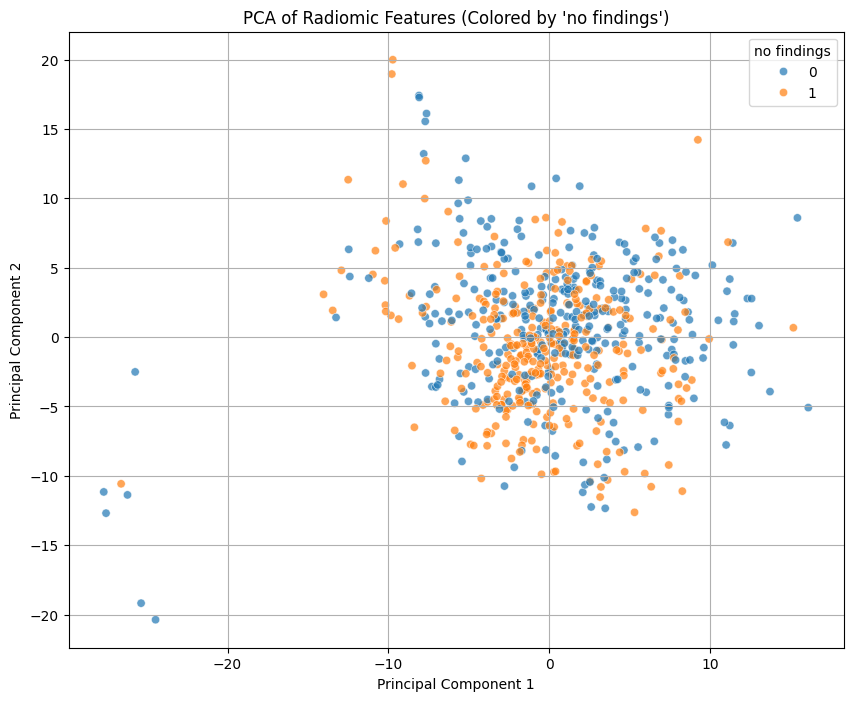

In [204]:
# --- 1. Load the Final, Combined Feature File ---
try:
    radiomics_df = pd.read_csv("all_radiomics_features.csv")
    print(f"✅ Successfully loaded {len(radiomics_df)} feature sets from 'all_radiomics_features.csv'.")
except FileNotFoundError:
    print("❌ Error: 'all_radiomics_features.csv' not found. Please re-run the feature extraction cell.")

# --- 2. Prepare Data for PCA ---
# Select only the numeric feature columns for PCA
identifier_cols = ['subject_id', 'study_id', 'dicom_id']
features = radiomics_df.drop(columns=identifier_cols)
features = features.select_dtypes(include=np.number)

# Scale the features before applying PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- 3. Run PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)

# --- 4. Prepare Labels for Plotting ---
# Create a new DataFrame from the encoded labels with proper column names
encoded_labels_df = pd.DataFrame(encoded_labels, columns=mlb.classes_)
labels_with_ids = pd.concat([metadata_df[['dicom_id']], encoded_labels_df], axis=1)

# Merge labels with radiomics data to ensure the rows align correctly
full_df = pd.merge(radiomics_df[['dicom_id']], labels_with_ids, on='dicom_id', how='left')

# Choose a label to visualize. You can change this to any other available label.
label_to_plot = 'no findings'
hue_labels = full_df[label_to_plot]
print(f"\nPlotting by label: '{label_to_plot}'")


# --- 5. Plot the Results ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hue_labels, alpha=0.7)
plt.title(f"PCA of Radiomic Features (Colored by '{label_to_plot}')")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title=label_to_plot)
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>9.</b> Identify the most suitable dimension reduction technique to split the data according to the target label. Print the explained variance ratio, and identify the most informative features (N=20).
</div>

In [205]:
# Explained variance per component
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_var)

Explained variance ratio: [0.29410468 0.24465492]


In [206]:
# Get the loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so rows are features
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns # Use the 'features' dataframe's columns as index
)

# Show top contributing features for PC1
top_features_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(20)
print("\nTop 20 features contributing to PC1:")
print(top_features_pc1)


Top 20 features contributing to PC1:
original_glcm_Id                                   0.172668
original_glcm_Idm                                  0.172131
original_gldm_SmallDependenceEmphasis              0.172122
original_glcm_InverseVariance                      0.171913
original_glszm_ZonePercentage                      0.171536
original_gldm_DependenceNonUniformityNormalized    0.171369
original_glrlm_RunLengthNonUniformityNormalized    0.170983
original_glrlm_ShortRunEmphasis                    0.169937
original_glrlm_RunPercentage                       0.169642
original_glszm_SizeZoneNonUniformityNormalized     0.167824
original_glszm_SmallAreaEmphasis                   0.166554
original_glrlm_LongRunEmphasis                     0.166328
original_gldm_LargeDependenceEmphasis              0.165799
original_glcm_DifferenceEntropy                    0.162499
original_glrlm_RunVariance                         0.162266
original_glcm_DifferenceAverage                    0.160356
or

In [207]:
# COMPLETE with code to add a new column 'dicom_id' to the radiomics dataframe
# and merge it with the labels dataframe.
df = radiomics_df.merge(labels_df, on = ['dicom_id', 'subject_id', 'study_id'])
df.to_csv('radiomics.csv')
df.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject_id,study_id,dicom_id,labels
0,3.1.1.dev111+g8ed579383,2.0.2,2.5.2,1.8.0,3.12.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d348c54cc956cd548e8ca77362e2c6cb027c5642,2D,"(0.139, 0.139)",...,1.720752,0.196538,0.001423,13287.944168,0.323283,7.476010,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,3.1.1.dev111+g8ed579383,2.0.2,2.5.2,1.8.0,3.12.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},809016247c101494d20f7cc8cc612ec174f2d8f9,2D,"(0.139, 0.139)",...,1.382328,0.196013,0.001483,13086.039343,0.319079,7.758952,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,3.1.1.dev111+g8ed579383,2.0.2,2.5.2,1.8.0,3.12.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},53987a992abeaabfef99f69642af82edc1448d14,2D,"(0.19444444, 0.19444444)",...,0.704367,0.115108,0.002027,25938.301412,0.348266,18.382448,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,3.1.1.dev111+g8ed579383,2.0.2,2.5.2,1.8.0,3.12.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},8d4ef8376f9cef2256186af6859bd55699cc6f2a,2D,"(0.139, 0.139)",...,1.378687,0.064390,0.003098,13506.085773,0.315555,15.110863,18000379,51568340,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,3.1.1.dev111+g8ed579383,2.0.2,2.5.2,1.8.0,3.12.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7ccab0e785995cc1b7bb1a9a9f270973b8e2c07c,2D,"(0.139, 0.139)",...,0.717886,0.088607,0.002337,18175.381028,0.432601,12.103471,18000379,51817182,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
